In [1]:
import pandas as pd
import math
import matplotlib as plt
import seaborn as sns

In [2]:
pd.set_option("display.max_rows", None, "display.max_columns", None)
%matplotlib inline
sns.set(rc = {'figure.figsize':(15,8)})

In [3]:
dataset = pd.read_excel("2019 Winter Data Science Intern Challenge Data Set.xlsx")

In [4]:
dataset.head()

,order_id,shop_id,user_id,order_amount,total_items,payment_method,created_at
0,1,53,746,224,2,cash,2017-03-13 12:36:56.190
1,2,92,925,90,1,cash,2017-03-03 17:38:51.999
2,3,44,861,144,1,cash,2017-03-14 04:23:55.595
3,4,18,935,156,1,credit_card,2017-03-26 12:43:36.649
4,5,18,883,156,1,credit_card,2017-03-01 04:35:10.773


In [5]:
naive_aov = sum(list(dataset["order_amount"]))/len(dataset)
print("The naively calculated average order value is $"+str(round(naive_aov,2)))

The naively calculated average order value is $3145.13


### Limitations of this calculation

Since it is mentioned that **"each of these shops sells only one model of shoe"**, by taking the average value across all models we are making two assumptions:
1. all the models have relatively similar popularity. By taking the average across the dataset, we are expecting every store to experience comparable order sizes or total_items of each order.
2. all models have relatively similar selling price and can be assessed together. Therefore, the if the sneaker costs are similar, then the average order value alculated across the dataset will be an effective metric. 

However, the data seems contrary to these assumptions.

##### ASSUMPTION 1

<AxesSubplot:xlabel='shop_id', ylabel='total_items'>

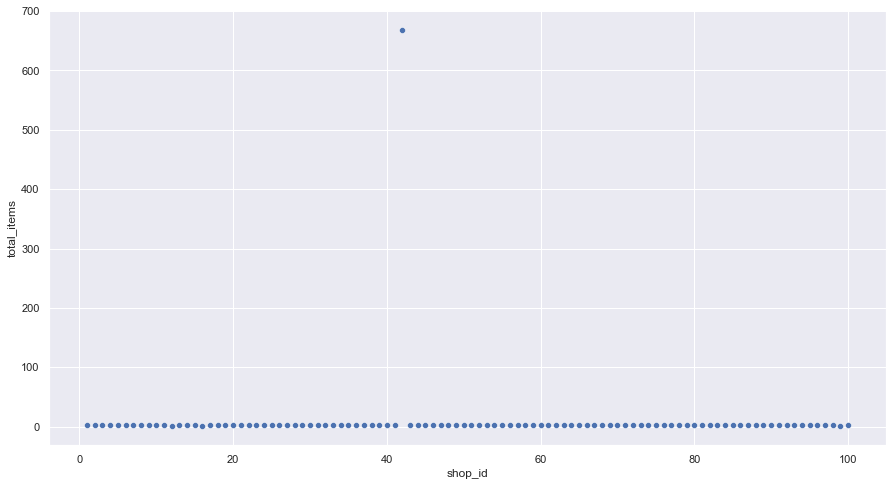

In [6]:
# Average Order Size by store
avg_order_size_pivot = dataset.pivot_table(index =['shop_id'],
                       values =['total_items'],
                       aggfunc ='mean')

# Scatter Plot of Average Order Size by store
sns.scatterplot(data=avg_order_size_pivot, x="shop_id", y="total_items")

In [7]:
print("The store with the largest Average Order Size has Store ID", avg_order_size_pivot['total_items'].idxmax(),"\nTheir Avg Order Size is",max(avg_order_size_pivot['total_items']))

The store with the largest Average Order Size has Store ID 42 
Their Avg Order Size is 667.9019607843137


The above plot shows that $Shop 42$ is acting as an outlier within the dataset of orders placed per Shop. Let us dig deeper to find out the reason for this skewness.

<AxesSubplot:xlabel='user_id', ylabel='total_items'>

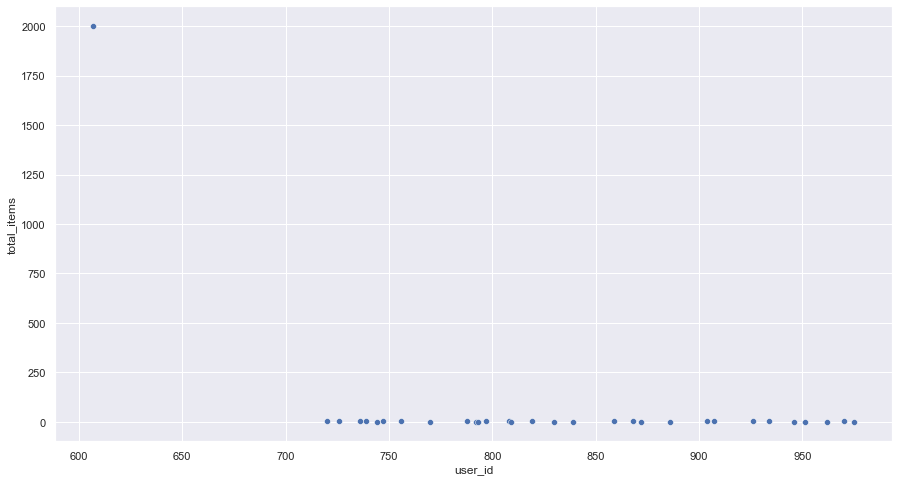

In [8]:
# Filter for orders placed in Shop 42
shop42_orders = dataset[dataset["shop_id"]==42]

# Average Order Size by user for all the orders in Shop 42
shop42_avg_order_size_by_user = shop42_orders.pivot_table(index =['user_id'],
                       values =['total_items'],
                       aggfunc ='mean')

# Scatter plot of average order size by user in Shop 42
sns.scatterplot(data=shop42_avg_order_size_by_user, x="user_id", y="total_items")

In [9]:
print("The user with the largest Average Order Size in Store, with ID 42, has User ID", shop42_avg_order_size_by_user['total_items'].idxmax(),"\nThey placed orders with Avg Size",max(shop42_avg_order_size_by_user['total_items']),"units")

The user with the largest Average Order Size in Store, with ID 42, has User ID 607 
They placed orders with Avg Size 2000.0 units


In [10]:
# List of orders placed by USER with ID 607
dataset[dataset["user_id"]==607]

,order_id,shop_id,user_id,order_amount,total_items,payment_method,created_at
15,16,42,607,704000,2000,credit_card,2017-03-07 04:00:00
60,61,42,607,704000,2000,credit_card,2017-03-04 04:00:00
520,521,42,607,704000,2000,credit_card,2017-03-02 04:00:00
1104,1105,42,607,704000,2000,credit_card,2017-03-24 04:00:00
1362,1363,42,607,704000,2000,credit_card,2017-03-15 04:00:00
1436,1437,42,607,704000,2000,credit_card,2017-03-11 04:00:00
1562,1563,42,607,704000,2000,credit_card,2017-03-19 04:00:00
1602,1603,42,607,704000,2000,credit_card,2017-03-17 04:00:00
2153,2154,42,607,704000,2000,credit_card,2017-03-12 04:00:00
2297,2298,42,607,704000,2000,credit_card,2017-03-07 04:00:00


In [11]:
# The list of UNIQUE Store_IDs from where user 607 purchased their items
list(set(dataset[dataset["user_id"]==607]["shop_id"]))

[42]

Therefore, user with ID **607** appears to be consistently placing a large order for the sneakers sold by Store *42*. They seem to sell a very popular model of sneakers which other stores do not have access to. Thus, their very high popularity is skewing the average order value metric, which is being naively calculated across the entire dataset.

If we remove this shop's data and plot the average order sizes, then the data is no longer skewed and the order sizes across stores becomes comparable.

<AxesSubplot:xlabel='shop_id', ylabel='total_items'>

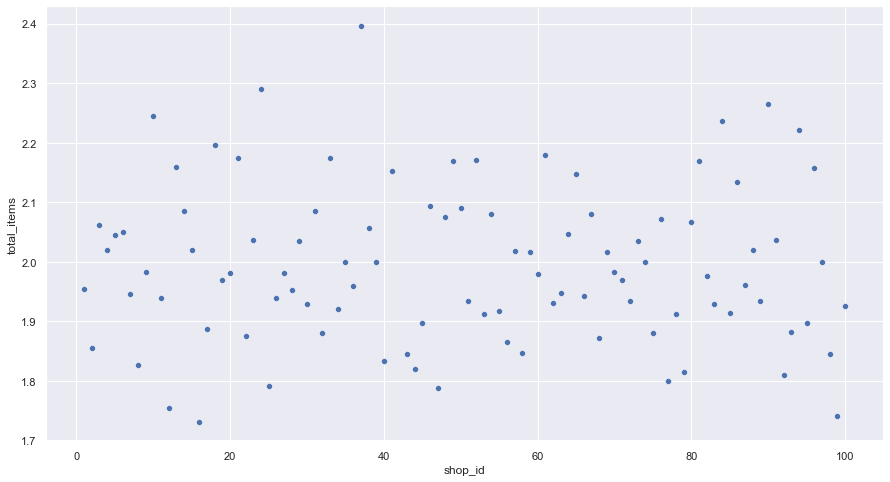

In [12]:
# Scatter Plot of Average Order Size by store, except Shop with ID 42.
sns.scatterplot(data=avg_order_size_pivot.drop([42]), x="shop_id", y="total_items")

Since, all the order sizes are also not comparable our $Assumption1$ stands invalidated.

##### ASSUMPTION 2

<AxesSubplot:xlabel='shop_id', ylabel='sneaker_price'>

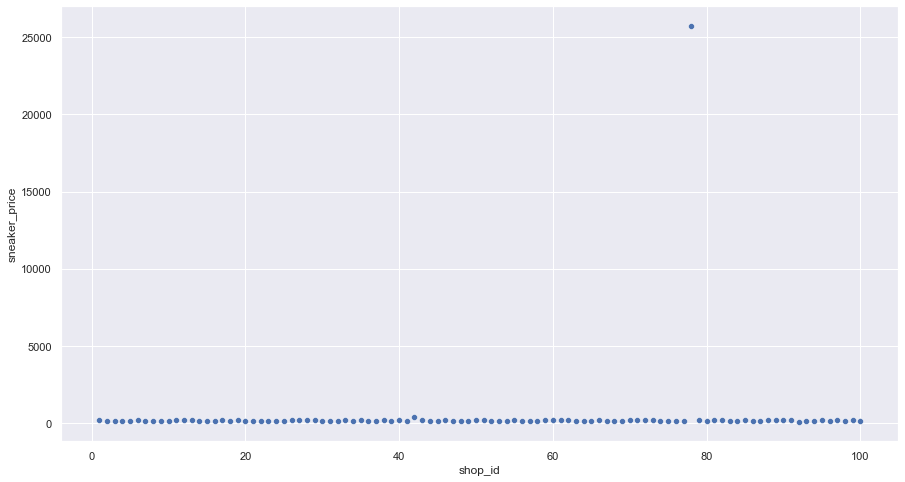

In [21]:
# Calculate selling price of sneaker in each order
dataset["sneaker_price"] = dataset["order_amount"]/dataset["total_items"]

# Calculate average cost of sneaker in each store
avg_sneaker_cost_pivot = dataset.pivot_table(index =['shop_id'],
                       values =['sneaker_price'],
                       aggfunc ='mean')

# Scatter plot of average sneaker price per shop
sns.scatterplot(data=avg_sneaker_cost_pivot, x="shop_id", y="sneaker_price")

In [23]:
print("The shop with the largest Average Sneaker Price has Shop ID", avg_sneaker_cost_pivot['sneaker_price'].idxmax(),"\nTheir sneaker model's Avg Price is",max(avg_sneaker_cost_pivot['sneaker_price']),"per unit")

The shop with the largest Average Sneaker Price has Shop ID 78 
Their sneaker model's Avg Price is 25725.0 per unit


The above plot shows that we have an outlier in the sneaker cost department too. One of the models being sold by a store is very expensive as compared to those sold by other stores. This will skew the average order value calculated across the dataset.

If we remove this shop from our calculations then the average sneaker costs across stores becomes more comparable.

<AxesSubplot:xlabel='shop_id', ylabel='sneaker_price'>

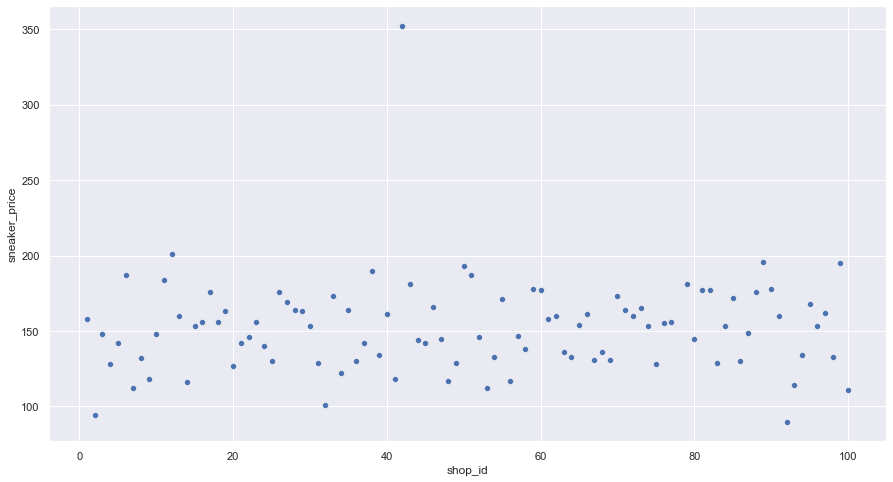

In [24]:
# Scatter Plot of Average Order Size by store, except Shop with ID 42.
sns.scatterplot(data=avg_sneaker_cost_pivot.drop([78]), x="shop_id", y="sneaker_price")

Since, all the sneaker costs are also not comparable our $Assumption2$ stands invalidated.

#### Conclusion

Since our assumptions are invalid, I feel calculating the average order value across the entire dataset is not an accurate representation of the sales.

### Alternate Metric

I believe the Average Order Value Per Store/Model is a more wholesome metric to evaluate the order data. It treats every sneaker model uniquely and also takes into consideration the location of each shop, which can also affect the sales

### Average Order Value Per Store/Model Calculation

In [17]:
# Average Order Size by store
avg_order_value_by_shop_pivot = dataset.pivot_table(index =['shop_id'],
                       values =['order_amount'],
                       aggfunc ='mean')

avg_order_value_by_shop_pivot.columns = ["Average Order Value"]

In [18]:
avg_order_value_by_shop_pivot

,Average Order Value
shop_id,
1,308.818182
2,174.327273
3,305.250000
4,258.509804
5,290.311111
6,383.508475
7,218.000000
8,241.043478
9,234.000000


In the above metric we can clearly see that Shops with ID **42** and **78** have abnormally high Average Order Values, which are not comparable to the other shops. This gives a well-rounded outlook of the ground reality. 